# I. Monthly data

# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima
import optuna

In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
data = pd.read_excel('data.xlsx')

In [4]:
data.set_index(pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1)), inplace = True)

In [5]:
data.drop(['YEAR','MONTH','HANSGN'], axis = 1, inplace = True)

In [6]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


<AxesSubplot:>

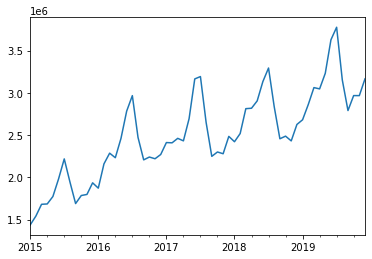

In [7]:
data['TTT'].plot()

In [8]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [9]:
test

,TTT
2019-01-01,2680573
2019-02-01,2860436
2019-03-01,3061302
2019-04-01,3045879
2019-05-01,3230488
2019-06-01,3627333
2019-07-01,3775263
2019-08-01,3151724
2019-09-01,2789760
2019-10-01,2966733


# 2. Time Series Analysis

In [10]:
# Stationarity test:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.968342
Critical Values at 0.05: -2.94
p-value: 0.001586
Stationary


In [11]:
kpss_test = kpss(train)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.795515
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

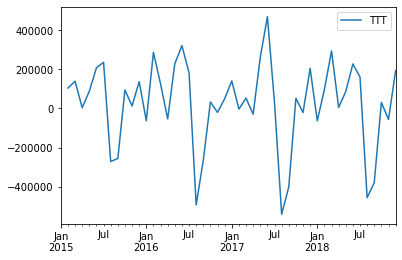

In [12]:
train1 = train - train.shift(1)
train1.plot()

In [13]:
# unit-root ("difference stationary") test:
# Difference-stationary: If a time series can be made stationary by differencing, it is said to contain a unit root.
# In essence, this means that the current value of a series yt is equal to its last value yt−1 plus an error ϵt
# i.e. yt=ayt−1+ϵt with |a|=1
# Variables that show this behaviour are also said to be integrated of order d, or I(d)
# which means that d differences are neccesary to render a series stationary.
result = adfuller(train1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -6.515841
p-value: 0.000000
Stationary


In [14]:
# trend-stationary test:
kpss_test = kpss(train1.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.071539
Critical Values @ 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


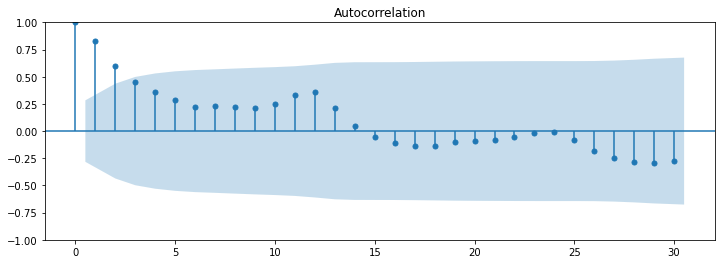

In [15]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


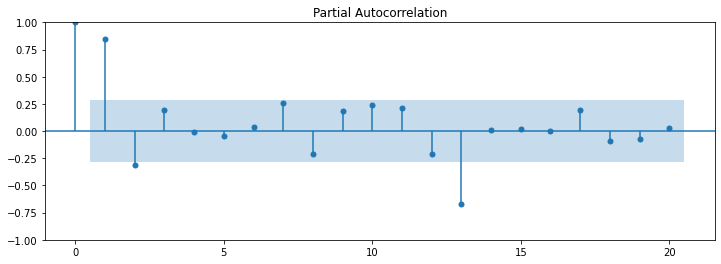

In [16]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 1 differencing, d value should be 1
- Based on ACF plot, q value should be 3
- Based on PACF plot, p value should be 1

# 3. Build models

## 3.1. SARIMA without boxcox

In [17]:
model = auto_arima(train,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=924.288, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=927.295, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=924.722, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=924.927, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=924.383, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=923.980, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=946.087, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=926.278, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=924.632, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=925.333, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=925.632, Time=0.05 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 1.029 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -459.990
Date:                            Tue, 28 Feb 2023   AIC                            923.980
Time:                                    16:05:41   BIC                            927.090
Sample:                                01-01-2015   HQIC                           925.053
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1396      0.118     -1.181      0.237      -0.371       0.092
sigma2       1.37e+10   1.17e-13   1.17e+23      0.000    1.37e+10    1.37e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.54   Prob(JB):                         0.85
Heteroskedasticity (H):               1.14   Skew:                            -0.14
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [18]:
# Predict using the best model from auto_arima:
test['predict'] = pd.Series(model.predict(12).astype('int64'))

In [19]:
test

,TTT,predict
2019-01-01,2680573,2590299
2019-02-01,2860436,2672974
2019-03-01,3061302,2933866
2019-04-01,3045879,2933991
2019-05-01,3230488,3045351
2019-06-01,3627333,3307231
2019-07-01,3775263,3449552
2019-08-01,3151724,2980691
2019-09-01,2789760,2597626
2019-10-01,2966733,2631500


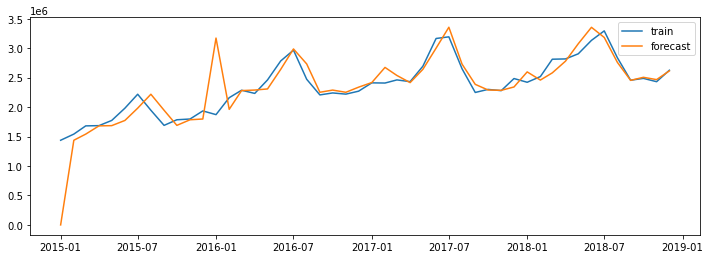

In [20]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='train')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

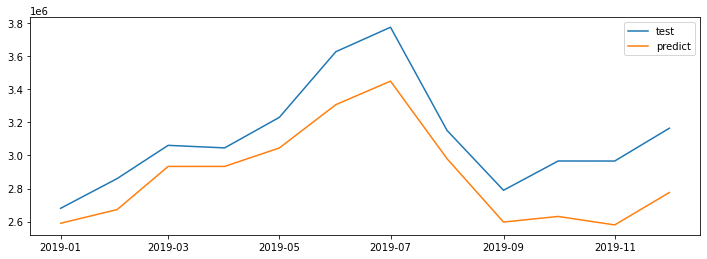

In [21]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [22]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)

In [23]:
results = pd.DataFrame({'Method':'SARIMA', 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"


## 3.2. SARIMA with boxcox (trend stationary)

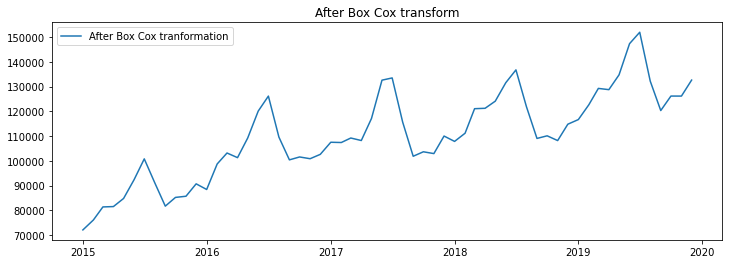

In [24]:
data_boxcox = pd.Series(boxcox(data['TTT'])[0], index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [25]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -2.315488
Critical Values at 0.05: -2.92
p-value: 0.167021
Not stationary


In [26]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 1.059631
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


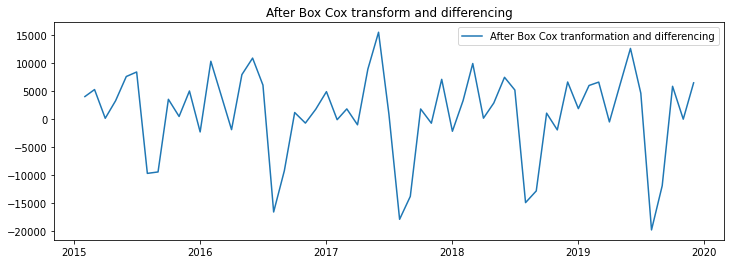

In [27]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [28]:
data_boxcox_diff.dropna(inplace=True)

In [29]:
# Stationarity test:
result = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -1.697966
Critical Values at 0.05: -2.93
p-value: 0.432161
Not stationary


In [30]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.049471
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


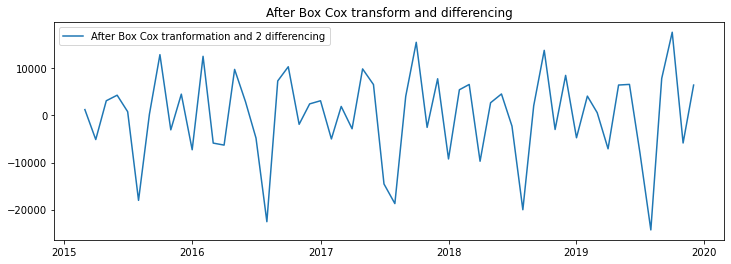

In [31]:
data_boxcox_diff2 = pd.Series(data_boxcox_diff - data_boxcox_diff.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff2, label='After Box Cox tranformation and 2 differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [32]:
data_boxcox_diff2.dropna(inplace=True)

In [33]:
# Stationarity test:
result = adfuller(data_boxcox_diff2)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -10.868264
Critical Values at 0.05: -2.93
p-value: 0.000000
Stationary


In [34]:
kpss_test = kpss(data_boxcox_diff2)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.362500
Critical Values at 0.05: 0.46
p-value: 0.093319
Stationary


In [35]:
data_boxcox_diff2.tail()

2019-08-01                -24,334
2019-09-01                  7,867
2019-10-01                 17,698
2019-11-01                 -5,850
2019-12-01                  6,465
dtype: float64

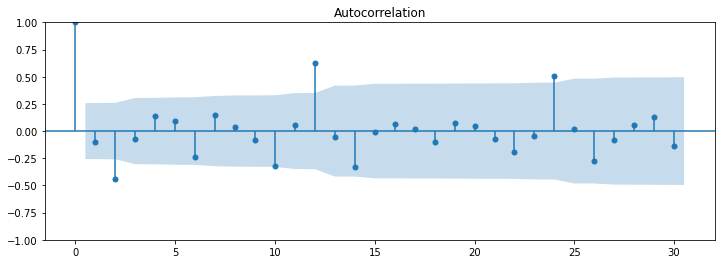

In [36]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff2, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


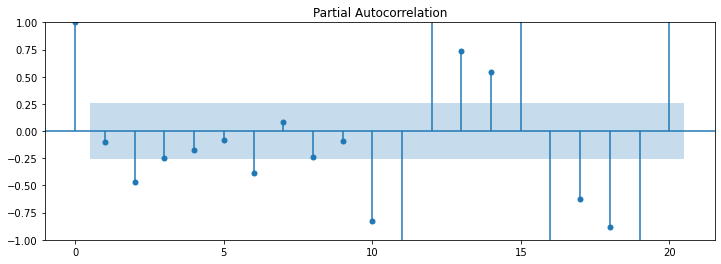

In [37]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff2, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 2 differencing, d value should be 2
- Based on ACF plot, q value should be 0
- Based on PACF plot, p value should be 2

In [38]:
train_data_boxcox = data_boxcox[:-12]
test_data_boxcox = data_boxcox[-12:]

In [39]:
test_data_boxcox

2019-01-01                116,660
2019-02-01                122,647
2019-03-01                129,232
2019-04-01                128,730
2019-05-01                134,702
2019-06-01                147,282
2019-07-01                151,890
2019-08-01                132,164
2019-09-01                120,305
2019-10-01                126,144
2019-11-01                126,134
2019-12-01                132,589
dtype: float64

In [40]:
model = auto_arima(train_data_boxcox,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=686.362, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=688.344, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=686.729, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=687.050, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=686.787, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=686.380, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=688.665, Time=0.35 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=687.240, Time=0.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=686.941, Time=0.25 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=687.206, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=687.290, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=688.485, Time=0.26 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -340.181
Date:                              Tue, 28 Feb 2023   AIC                            686.362
Time:                                      16:05:46   BIC                            691.028
Sample:                                  01-01-2015   HQIC                           687.972
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9234      1.643     -0.562      0.574      -4.145       2.298
ma.S.L12       0.8747      1.887      0.464      0.643      -2.823       4.572
sigma2      1.602e+07   7.65e-07   2.09e+13      0.000     1.6e+07     1.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.36   Prob(JB):                         0.83
Heteroskedasticity (H):               1.28   Skew:                            -0.25
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.38e+28. Standard errors may be unstable.
"""

In [41]:
# Predict using the best model from auto_arima:
# data['TTT']
# inv_boxcox(boxcox(data['TTT'])[0],boxcox(data['TTT'])[1])
test['predict_boxcox'] = pd.Series(model.predict(12).astype('int64'))
test['predict'] = inv_boxcox(test['predict_boxcox'],boxcox(data['TTT'])[1])

In [42]:
test

,TTT,predict,predict_boxcox
2019-01-01,2680573,"2,746,124",118852
2019-02-01,2860436,"2,820,499",121325
2019-03-01,3061302,"3,112,306",130888
2019-04-01,3045879,"3,119,620",131125
2019-05-01,3230488,"3,217,742",134292
2019-06-01,3627333,"3,476,755",142548
2019-07-01,3775263,"3,639,467",147662
2019-08-01,3151724,"3,162,290",132505
2019-09-01,2789760,"2,752,572",119067
2019-10-01,2966733,"2,793,770",120438


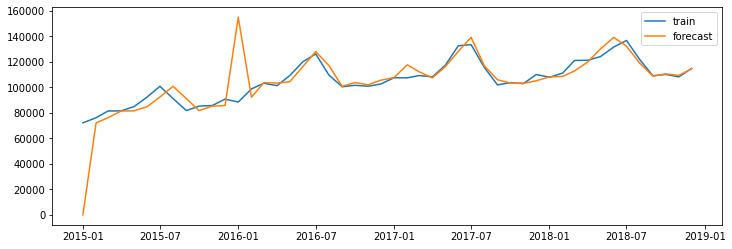

In [43]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train_data_boxcox, label='train')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

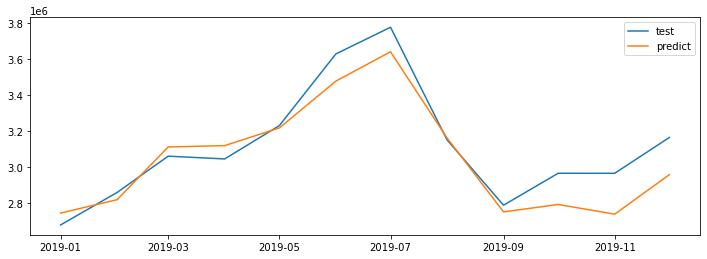

In [44]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [45]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)
tempResults = pd.DataFrame({'Method':'SARIMA with boxcox', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"


## 3.3. Prophet

In [46]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import utils

In [47]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [48]:
help(Prophet.fit)

Help on function fit in module prophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet object.

In [49]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


In [50]:
data['date'] = data.index

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TTT     60 non-null     int64         
 1   date    60 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [52]:
data = data.rename(columns={'date': 'ds', 'TTT': 'y'})

In [53]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [54]:
# set the uncertainty interval to 90% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.9)

In [55]:
my_model.fit(train)

16:05:48 - cmdstanpy - INFO - Chain [1] start processing
16:05:48 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
55,2019-08-01
56,2019-09-01
57,2019-10-01
58,2019-11-01
59,2019-12-01


In [57]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
48,2019-01-01,"2,621,989","2,528,692","2,732,340"
49,2019-02-01,"2,762,466","2,668,217","2,868,046"
50,2019-03-01,"2,900,542","2,801,451","2,996,680"
51,2019-04-01,"2,919,307","2,816,429","3,022,184"
52,2019-05-01,"2,997,933","2,903,012","3,099,012"
53,2019-06-01,"3,211,643","3,112,016","3,321,646"
54,2019-07-01,"3,391,835","3,281,958","3,497,066"
55,2019-08-01,"3,028,472","2,921,817","3,134,834"
56,2019-09-01,"2,670,088","2,557,860","2,772,123"
57,2019-10-01,"2,703,863","2,595,837","2,815,468"


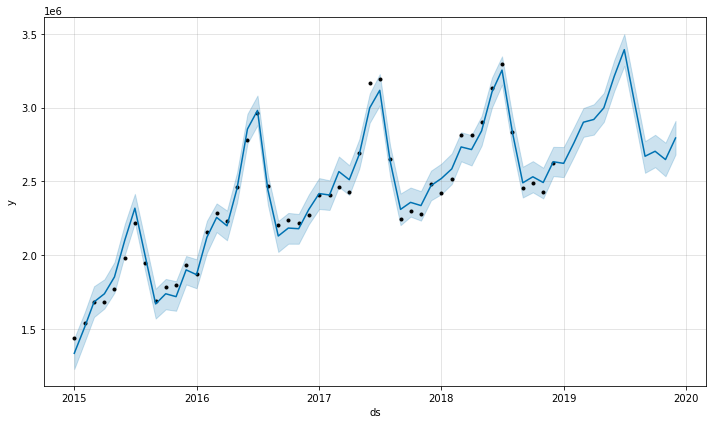

In [58]:
fig = my_model.plot(forecast, uncertainty=True)

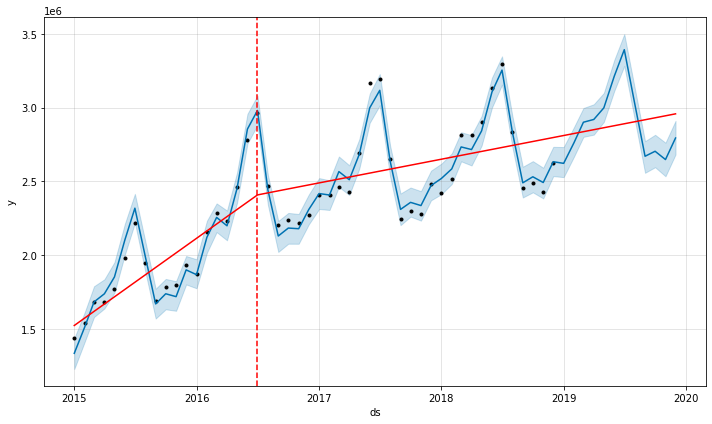

In [59]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [60]:
my_model.changepoints

1    2015-02-01
3    2015-04-01
4    2015-05-01
6    2015-07-01
7    2015-08-01
9    2015-10-01
10   2015-11-01
12   2016-01-01
13   2016-02-01
15   2016-04-01
16   2016-05-01
18   2016-07-01
19   2016-08-01
21   2016-10-01
22   2016-11-01
24   2017-01-01
25   2017-02-01
27   2017-04-01
28   2017-05-01
30   2017-07-01
31   2017-08-01
33   2017-10-01
34   2017-11-01
36   2018-01-01
37   2018-02-01
Name: ds, dtype: datetime64[ns]

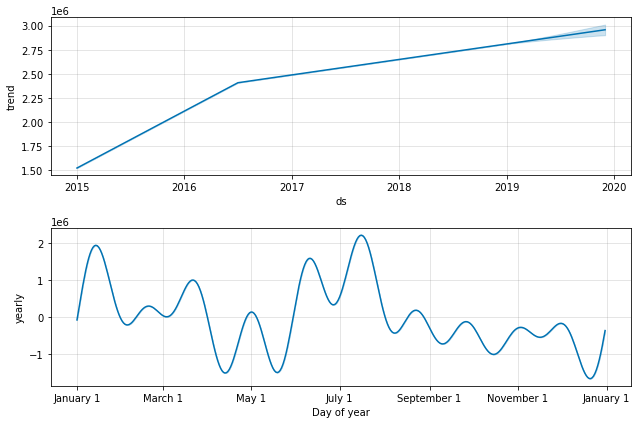

In [61]:
fig2 = my_model.plot_components(forecast)

In [62]:
forecast.set_index('ds',inplace=True)

In [63]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2015-01-01,"1,523,904","1,228,871","1,437,282","1,523,904","1,523,904","-188,519","-188,519","-188,519","-188,519","-188,519","-188,519",0,0,0,"1,335,386"
2015-02-01,"1,574,044","1,412,337","1,611,908","1,574,044","1,574,044","-61,666","-61,666","-61,666","-61,666","-61,666","-61,666",0,0,0,"1,512,378"
2015-03-01,"1,619,332","1,581,343","1,789,709","1,619,332","1,619,332","64,103","64,103","64,103","64,103","64,103","64,103",0,0,0,"1,683,436"
2015-04-01,"1,669,472","1,639,225","1,836,986","1,669,472","1,669,472","69,244","69,244","69,244","69,244","69,244","69,244",0,0,0,"1,738,716"
2015-05-01,"1,717,995","1,746,013","1,952,628","1,717,995","1,717,995","134,684","134,684","134,684","134,684","134,684","134,684",0,0,0,"1,852,679"
2015-06-01,"1,768,135","2,003,596","2,212,157","1,768,135","1,768,135","334,770","334,770","334,770","334,770","334,770","334,770",0,0,0,"2,102,905"
2015-07-01,"1,816,658","2,218,981","2,415,269","1,816,658","1,816,658","501,777","501,777","501,777","501,777","501,777","501,777",0,0,0,"2,318,434"
2015-08-01,"1,866,798","1,889,682","2,095,137","1,866,798","1,866,798","124,789","124,789","124,789","124,789","124,789","124,789",0,0,0,"1,991,587"
2015-09-01,"1,916,938","1,570,969","1,772,786","1,916,938","1,916,938","-247,220","-247,220","-247,220","-247,220","-247,220","-247,220",0,0,0,"1,669,717"


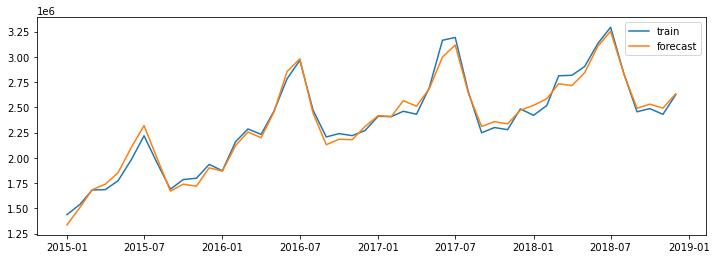

In [64]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train['y'], label='train')
plt.plot(forecast['yhat'][:-12], label='forecast')
plt.legend(loc='best')
plt.show()

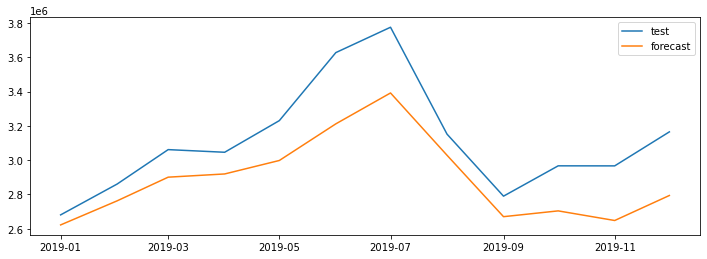

In [65]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['y'], label='test')
plt.plot(forecast['yhat'][-12:], label='forecast')
plt.legend(loc='best')
plt.show()

In [66]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-12:])).round(2)
mape = np.round(np.mean(np.abs(test['y']-forecast['yhat'][-12:])/test['y'])*100,2)
tempResults = pd.DataFrame({'Method':'prophet default', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"


# II. Daily data

# 1. Import and clean data

In [67]:
dom = pd.read_excel('dom.xlsx')

In [68]:
dom.head()

,DATE,Pax,deaths,cases
0,2015-01-01,52356,0,0
1,2015-01-02,47811,0,0
2,2015-01-03,49555,0,0
3,2015-01-04,57680,0,0
4,2015-01-05,50193,0,0


In [69]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2956 non-null   datetime64[ns]
 1   Pax     2956 non-null   int64         
 2   deaths  2956 non-null   int64         
 3   cases   2956 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 92.5 KB


In [70]:
dom.set_index('DATE', inplace = True, drop = True)

In [71]:
dom_month = dom.resample('M').sum()

In [72]:
dom_month.tail()

,Pax,deaths,cases
DATE,,,
2022-10-31,3296298,15,24588
2022-11-30,3181868,9,12949
2022-12-31,3289334,12,9721
2023-01-31,3828294,2,1338
2023-02-28,382182,0,26


In [73]:
dom_month.drop('2023-02-28', inplace = True)

In [74]:
dom_train = dom_month[:-6].copy()
dom_test = dom_month[-6:].copy()

In [75]:
# import covid lockdown dummy variable:
lockdown = pd.read_excel('lockdown.xlsx')

In [76]:
lockdown.tail()

,DATE,lockdown
2951,2023-01-30,0
2952,2023-01-31,0
2953,2023-02-01,0
2954,2023-02-02,0
2955,2023-02-03,0


In [77]:
lockdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      2956 non-null   datetime64[ns]
 1   lockdown  2956 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.3 KB


In [78]:
lockdown.set_index('DATE', inplace = True, drop = True)

In [79]:
lockdown_month = lockdown.resample('M').sum()

In [80]:
lockdown_month.drop('2023-02-28', inplace = True)

In [81]:
train_lockdown = lockdown_month[:-6].copy()
test_lockdown = lockdown_month[-6:].copy()

# 2. Time Series Analysis

<AxesSubplot:xlabel='DATE'>

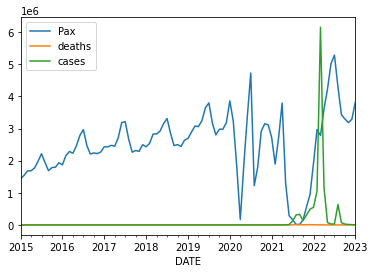

In [82]:
dom_month.plot()

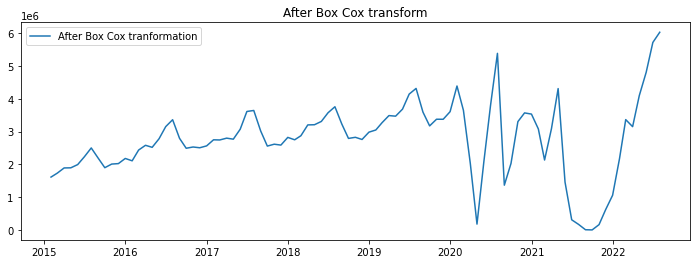

In [83]:
data_boxcox = pd.DataFrame(boxcox(dom_train['Pax'])[0], index = dom_train.index, columns = ['Pax'])

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [84]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.605387
Critical Values at 0.05: -2.90
p-value: 0.005659
Stationary


In [85]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.147516
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


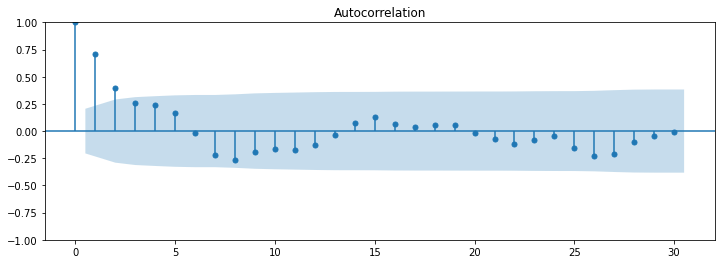

In [86]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


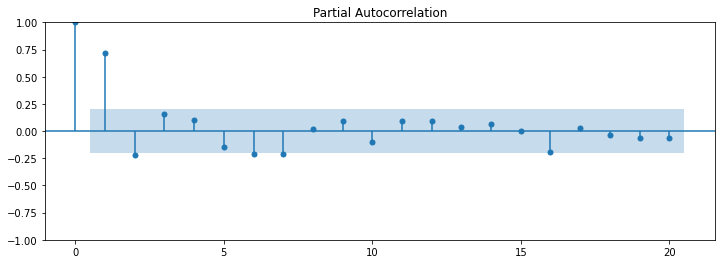

In [87]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox, ax=plt.gca(), lags = 20)
plt.show()

# 3. Build models

## 3.1. SARIMAX with lockdown day as dummy variable

In [88]:
model = auto_arima(data_boxcox,
                   d = None, max_d = 4,
                   start_p = 0,
                   max_p = 7,
                   start_q = 0,
                   max_q = 3,
                   m = 12,
                   seasonal = True,
                   trace = True, random_state = 99, X = train_lockdown)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2660.035, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2656.315, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2659.161, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2658.894, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2970.894, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2658.285, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2658.292, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2657.174, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2656.899, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2658.643, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.449 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1325.158
Date:                Tue, 28 Feb 2023   AIC                           2656.315
Time:                        16:05:52   BIC                           2663.815
Sample:                    01-31-2015   HQIC                          2659.339
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.891e+04   6.43e+04      0.760      0.447   -7.72e+04    1.75e+05
lockdown   -7.893e+04   5401.724    -14.612      0.000   -8.95e+04   -6.83e+04
sigma2      3.603e+11    3.6e+10     10.011      0.000     2.9e+11    4.31e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                26.45
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):              18.61   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
# Predict using the best model from auto_arima:
dom_test['predict_boxcox'] = pd.Series(model.predict(len(dom_test), X= test_lockdown).astype('int64'))
dom_test['predict'] = inv_boxcox(dom_test['predict_boxcox'],boxcox(dom_train['Pax'])[1])

In [90]:
dom_test

,Pax,deaths,cases,predict_boxcox,predict
DATE,,,,,
2022-08-31,4297335,25,634273,6067927,"5,327,432"
2022-09-30,3428134,31,68934,6116834,"5,369,987"
2022-10-31,3296298,15,24588,6165741,"5,412,539"
2022-11-30,3181868,9,12949,6214648,"5,455,088"
2022-12-31,3289334,12,9721,6263556,"5,497,635"
2023-01-31,3828294,2,1338,6312463,"5,540,178"


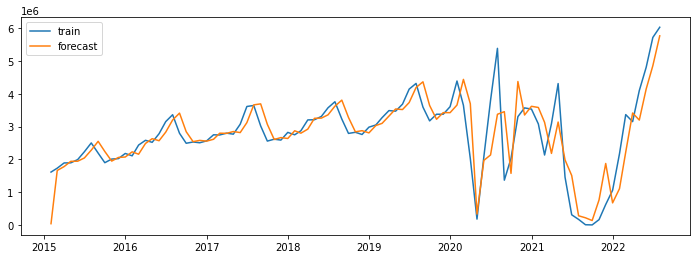

In [91]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='train')
plt.plot(model.predict_in_sample(X = train_lockdown), label='forecast')
plt.legend(loc='best')
plt.show()

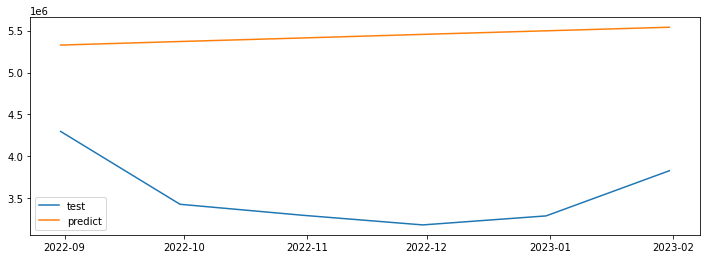

In [92]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(dom_test['Pax'], label='test')
plt.plot(dom_test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [93]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(dom_test['Pax'], dom_test['predict'])).round(2)
mape = np.round(np.mean(np.abs(dom_test['Pax']-dom_test['predict'])/dom_test['Pax'])*100,2)
tempResults = pd.DataFrame({'Method':'SARIMAX with covid period', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"
0,SARIMAX with covid period,55,"1,927,219"


## 3.2. Prophet

In [94]:
dom = pd.read_excel('dom.xlsx')

In [95]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2956 non-null   datetime64[ns]
 1   Pax     2956 non-null   int64         
 2   deaths  2956 non-null   int64         
 3   cases   2956 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 92.5 KB


In [96]:
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

<AxesSubplot:xlabel='ds'>

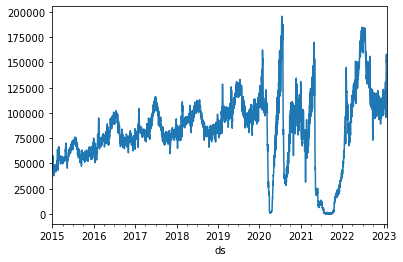

In [97]:
dom.set_index('ds')['y'].plot()

In [98]:
train = dom[dom['ds'] < '2023-01-01'].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy() # 2023 as test set

In [99]:
train

,ds,y,deaths,cases
0,2015-01-01,52356,0,0
1,2015-01-02,47811,0,0
2,2015-01-03,49555,0,0
3,2015-01-04,57680,0,0
4,2015-01-05,50193,0,0
...,...,...,...,...
2917,2022-12-27,104008,0,71
2918,2022-12-28,114073,0,163
2919,2022-12-29,108565,0,211
2920,2022-12-30,123337,0,366


In [100]:
holidays = pd.read_excel('holidays.xlsx')

In [101]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

In [102]:
def objective(trial):
    """Define the objective function"""

    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale',0.001,1),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale',0.001, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.001, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',1,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',5,40),
    }

    # Fit the model
    optuna_model = Prophet(**params,holidays = holidays, changepoints = changepoints, daily_seasonality = False)
    optuna_model.add_regressor('deaths')
    optuna_model.add_regressor('cases')
    optuna_model.fit(train)

    # Make predictions
    future_dates = optuna_model.make_future_dataframe(periods=len(test), freq='D')
    future_dates['deaths'] = dom['deaths'].copy()
    future_dates['cases'] = dom['cases'].copy()
    optuna_forecast = optuna_model.predict(future_dates)

    # Evaluate predictionsho
    rmse = np.sqrt(mean_squared_error(test.set_index('ds')['y'], optuna_forecast['yhat'][-len(test):])).round(2)
    return rmse

In [103]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-02-28 16:05:54,667] A new study created in memory with name: no-name-a1b325fa-a849-4436-9331-3e78fcb3aabf


In [104]:
study.optimize(objective, n_trials=5) #100

16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-02-28 16:05:57,413] Trial 0 finished with value: 15195.9 and parameters: {'changepoint_prior_scale': 0.672606280072161, 'seasonality_prior_scale': 4.881295914006597, 'holidays_prior_scale': 8.255126245184927, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 15}. Best is trial 0 with value: 15195.9.
16:05:58 - cmdstanpy - INFO - Chain [1] start processing
16:05:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-02-28 16:06:00,108] Trial 1 finished with value: 15920.07 and parameters: {'changepoint_prior_scale': 0.0476490247864463, 'seasonality_prior_scale': 9.906283367308491, 'holidays_prior_scale': 0.06925050470350826, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 22}. Best is trial 0 with value: 15195.9.
16:06:00 - cmdstanpy - INFO - Chain [1] start processing
16:06:03 - cmdstanpy - INFO -

In [105]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 5
Best trial:
  Value: 14610.39
  Params: 
    changepoint_prior_scale: 0.4122515756040955
    seasonality_prior_scale: 0.9695557473654088
    holidays_prior_scale: 1.4409659780779387
    seasonality_mode: additive
    yearly_seasonality: 4
    weekly_seasonality: 13


In [106]:
params = trial.params

In [107]:
my_model = Prophet(**params, holidays = holidays, changepoints = changepoints, daily_seasonality = False)
my_model.add_regressor('deaths')
my_model.add_regressor('cases')

In [108]:
my_model.fit(train)

16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:10 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
future_dates = my_model.make_future_dataframe(periods=len(test), freq='D')
future_dates['deaths'] = dom['deaths'].copy()
future_dates['cases'] = dom['cases'].copy()
future_dates.tail()

,ds,deaths,cases
2951,2023-01-30,0,13
2952,2023-01-31,0,74
2953,2023-02-01,0,15
2954,2023-02-02,0,11
2955,2023-02-03,0,0


In [110]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2951,2023-01-30,"136,427","118,203","154,828"
2952,2023-01-31,"131,813","114,091","150,524"
2953,2023-02-01,"119,807","100,744","136,951"
2954,2023-02-02,"121,125","104,658","140,060"
2955,2023-02-03,"126,483","109,539","144,520"


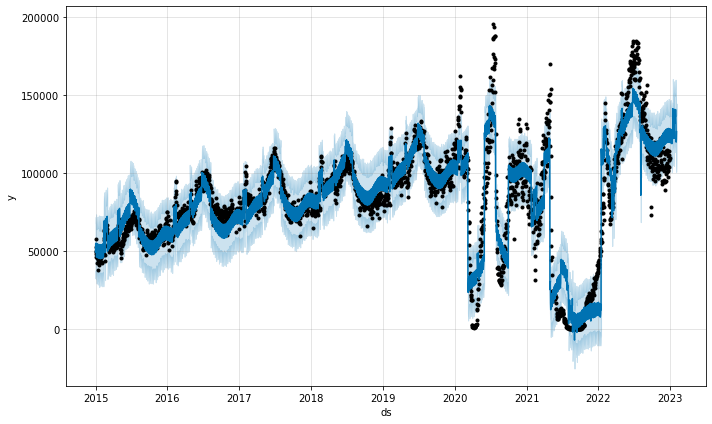

In [111]:
fig = my_model.plot(forecast, uncertainty=True)

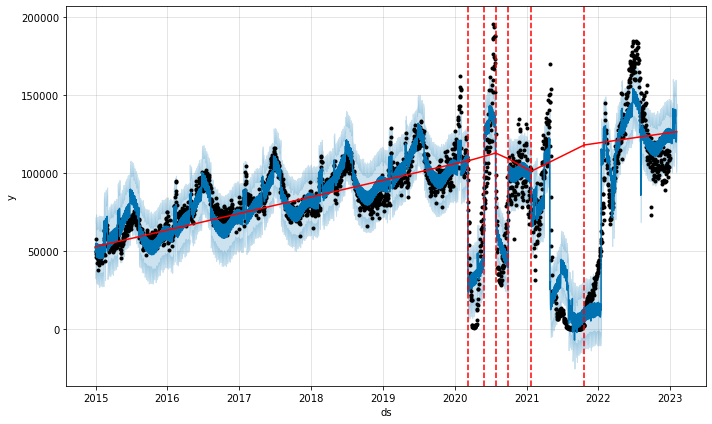

In [112]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [113]:
my_model.changepoints

0   2020-03-09
1   2020-05-31
2   2020-07-28
3   2020-09-30
4   2021-01-25
5   2021-03-31
6   2021-04-30
7   2021-10-22
Name: ds, dtype: datetime64[ns]

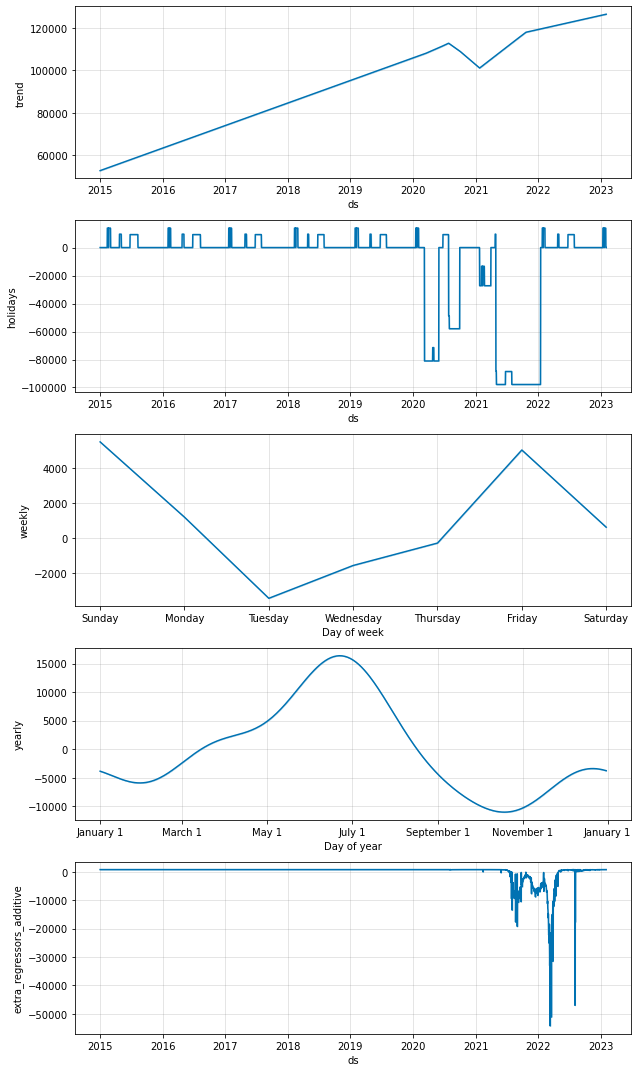

In [114]:
fig2 = my_model.plot_components(forecast)

In [115]:
forecast.set_index('ds',inplace=True)

In [116]:
forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Labor,Labor_lower,Labor_upper,Lunar,Lunar_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-01,"52,746","32,577","67,719","52,746","52,746",0,0,0,0,0,...,-271,-271,-271,"-3,824","-3,824","-3,824",0,0,0,"49,462"
2015-01-02,"52,775","37,342","71,847","52,775","52,775",0,0,0,0,0,...,"5,038","5,038","5,038","-3,901","-3,901","-3,901",0,0,0,"54,723"
2015-01-03,"52,804","32,076","67,706","52,804","52,804",0,0,0,0,0,...,635,635,635,"-3,982","-3,982","-3,982",0,0,0,"50,267"
2015-01-04,"52,833","37,598","73,498","52,833","52,833",0,0,0,0,0,...,"5,500","5,500","5,500","-4,067","-4,067","-4,067",0,0,0,"55,076"
2015-01-05,"52,863","32,640","68,587","52,863","52,863",0,0,0,0,0,...,"1,207","1,207","1,207","-4,156","-4,156","-4,156",0,0,0,"50,723"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30,"126,413","118,203","154,828","126,413","126,413",0,0,0,"13,916","13,916",...,"1,207","1,207","1,207","-5,918","-5,918","-5,918",0,0,0,"136,427"
2023-01-31,"126,432","114,091","150,524","126,432","126,432",0,0,0,"13,916","13,916",...,"-3,421","-3,421","-3,421","-5,914","-5,914","-5,914",0,0,0,"131,813"
2023-02-01,"126,450","100,744","136,951","126,450","126,450",0,0,0,0,0,...,"-1,549","-1,549","-1,549","-5,902","-5,902","-5,902",0,0,0,"119,807"


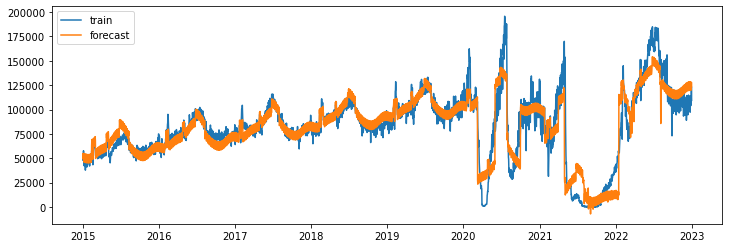

In [117]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train.set_index('ds')['y'], label='train')
plt.plot(forecast['yhat'][:-len(test)], label='forecast')
plt.legend(loc='best')
plt.show()

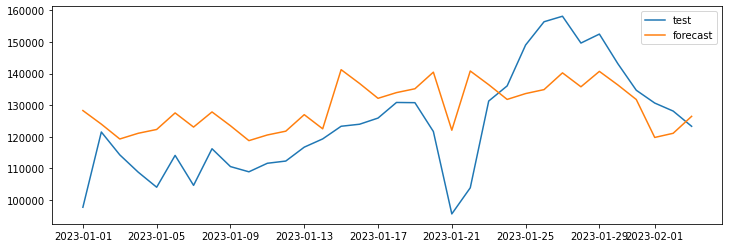

In [118]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test.set_index('ds')['y'], label='test')
plt.plot(forecast['yhat'][-len(test):], label='forecast')
plt.legend(loc='best')
plt.show()

In [119]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test.set_index('ds')['y'], forecast['yhat'][-len(test):])).round(2)
mape = np.round(np.mean(np.abs(test.set_index('ds')['y']-forecast['yhat'][-len(test):])/test.set_index('ds')['y'])*100,2)
tempResults = pd.DataFrame({'Method':'prophet with covid holidays', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"
0,SARIMAX with covid period,55,"1,927,219"
0,prophet with covid holidays,10,"14,610"


## 3.3. Neural Prophet

In [120]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [121]:
dom.drop(['deaths','cases'], inplace = True, axis = 1)

In [122]:
dom

,ds,y
0,2015-01-01,52356
1,2015-01-02,47811
2,2015-01-03,49555
3,2015-01-04,57680
4,2015-01-05,50193
...,...,...
2951,2023-01-30,143151
2952,2023-01-31,134741
2953,2023-02-01,130693
2954,2023-02-02,128154


In [123]:
train = dom[dom['ds'] < '2019-01-01'].copy()
val = dom[(dom['ds'] >= '2019-01-01')&(dom['ds'] < '2020-01-01')].copy()
covid = dom[(dom['ds'] >= '2020-01-01')&(dom['ds'] < '2022-01-01')].copy()
test = dom[dom['ds'] >= '2022-01-01'].copy()

In [124]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2019-01-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2019-01-01')&(holidays['ds'] < '2020-01-01')].copy()
covid_holidays = holidays[(holidays['ds'] >= '2020-01-01')&(holidays['ds'] < '2022-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2022-01-01'].copy()

In [125]:
help(NeuralProphet)

Help on class NeuralProphet in module neuralprophet.forecaster:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth: Literal['off', 'linear', 'discontinuous'] = 'linear', changepoints: Optional[list] = None, n_changepoints: int = 10, changepoints_range: float = 0.8, trend_reg: float = 0, trend_reg_threshold: Union[bool, float, NoneType] = False, trend_global_local: str = 'global', yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto', weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto', daily_seasonality: Union[Literal['auto'], bool, int] = 'auto', seasonality_mode: Literal['additive', 'multiplicative'] = 'additive', seasonality_reg: float = 0, season_global_local: Literal['global', 'local'] = 'global', n_forecasts: int = 1, n_lags: int = 0, num_hidden_layers: int = 0, d_hidden: Optional[int] = None, ar_reg: Optional[float] = None, learning_rate: Optional[float] = None, epochs: Optional[int] = None, batch_size: Optional[int] = None, loss_func: Union[str, 

In [126]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,20),
        'n_lags':trial.suggest_int('n_lags',1,len(test)*3),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        #'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,2)
    }

    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = pd.concat([train_df,val_df])
    optuna_forecast = optuna_model.predict(df=future_df)

    # Evaluate prediction
    rmse = np.sqrt(mean_squared_error(val.set_index('ds')['y'], optuna_forecast.set_index('ds')['yhat1'][-len(val):])).round(2)
    return rmse

In [127]:
study2 = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-02-28 16:06:16,176] A new study created in memory with name: no-name-c1a0959a-fb20-4275-a02f-8fb36a8c9776


In [128]:
study2.optimize(objective, n_trials=4) #100

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 188


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 35it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-02-28 16:06:47,044] Trial 0 finished with value: 67442.83 and parameters: {'trend_reg': 6.723113307749288, 'seasonality_reg': 4.931976152481779, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 12, 'n_lags': 357, 'ar_reg': 0.46695720506953253, 'learning_rate': 9.906283367308491}. Best is trial 0 with value: 67442.83.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 62it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-02-28 16:07:35,118] Trial 1 finished with value: 272880.34 and parameters: {'trend_reg': 0.06925050470350826, 'seasonality_reg': 7.720950979080404, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 19, 'n_lags': 474, 'ar_reg': 9.7395629682896, 'learning_rate': 5.244622739037026}. Best is trial 0 with value: 67442.83.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 30it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-02-28 16:08:06,192] Trial 2 finished with value: 59889.86 and parameters: {'trend_reg': 0.9370373198842281, 'seasonality_reg': 8.151753286543077, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 17, 'n_lags': 992, 'ar_reg': 2.215773717295777, 'learning_rate': 6.448702181331513}. Best is trial 2 with value: 59889.86.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% o

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-02-28 16:08:38,395] Trial 3 finished with value: 4825.11 and parameters: {'trend_reg': 0.9527210377133707, 'seasonality_reg': 4.17546606454509, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_seasonality': 10, 'n_lags': 93, 'ar_reg': 2.3504378152453462, 'learning_rate': 0.06652347380895983}. Best is trial 3 with value: 4825.11.


{'trend_reg': 0.9527210377133707, 'seasonality_reg': 4.17546606454509, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_seasonality': 10, 'n_lags': 93, 'ar_reg': 2.3504378152453462, 'learning_rate': 0.06652347380895983}. Best is trial 3 with value: 4821.95.

In [129]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study2.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 5
Best trial:
  Value: 4825.11
  Params: 
    trend_reg: 0.9527210377133707
    seasonality_reg: 4.17546606454509
    seasonality_mode: additive
    yearly_seasonality: 16
    weekly_seasonality: 10
    n_lags: 93
    ar_reg: 2.3504378152453462
    learning_rate: 0.06652347380895983


In [187]:
#params = study2.trials[4].params
params = trial.params

In [188]:
set_random_seed(98)

In [189]:
m = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, drop_missing = True, n_forecasts=3)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


Training: 0it [00:00, ?it/s]

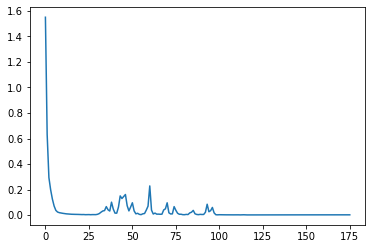

In [190]:
metrics = m.fit(train_df,
                freq="D",
                progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


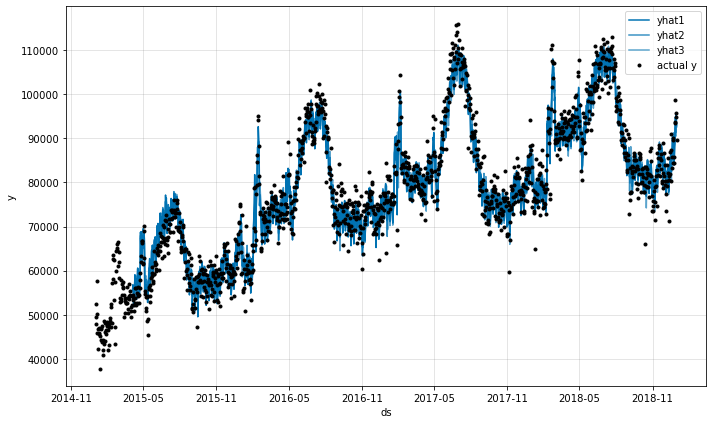

In [191]:
forecast = m.predict(train_df)
fig = m.plot(forecast)

In [192]:
test_df

,ds,y,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
0,2022-01-01,35818,0,0,0,1,0,0,0
1,2022-01-02,40412,0,0,0,1,0,0,0
2,2022-01-03,44108,0,0,0,1,0,0,0
3,2022-01-04,41768,0,0,0,1,0,0,0
4,2022-01-05,39718,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
394,2023-01-30,143151,0,0,0,0,0,1,0
395,2023-01-31,134741,0,0,0,0,0,1,0
396,2023-02-01,130693,0,0,0,0,0,0,0
397,2023-02-02,128154,0,0,0,0,0,0,0


In [193]:
predicted = m.predict(df = test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.749% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.751% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [194]:
predicted

,ds,y,yhat1,yhat2,yhat3,ar1,ar2,ar3,trend,season_yearly,season_weekly,events_multiplicative,event_Labor,event_Lunar,event_Summer,event_covid_1,event_covid_2,event_covid_3,event_covid_4
0,2022-01-01,"35,818",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,"40,412",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,"44,108",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,"41,768",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,"39,718",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2023-01-30,"143,151","140,880","140,379","142,157","76,864","76,363","78,141","24,697","-2,522","35,937","5,903",-0,"5,903",-0,0,0,0,0
395,2023-01-31,"134,741","133,255","136,353","137,556","72,368","75,466","76,670","24,703","-2,602","32,884","5,900",-0,"5,900",-0,0,0,0,0
396,2023-02-01,"130,693","127,593","130,886","133,862","70,610","73,903","76,879","24,709","-2,633","34,907",-0,-0,-0,-0,0,0,0,0
397,2023-02-02,"128,154","127,127","129,141","131,571","68,952","70,966","73,396","24,715","-2,609","36,069",-0,-0,-0,-0,0,0,0,0


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


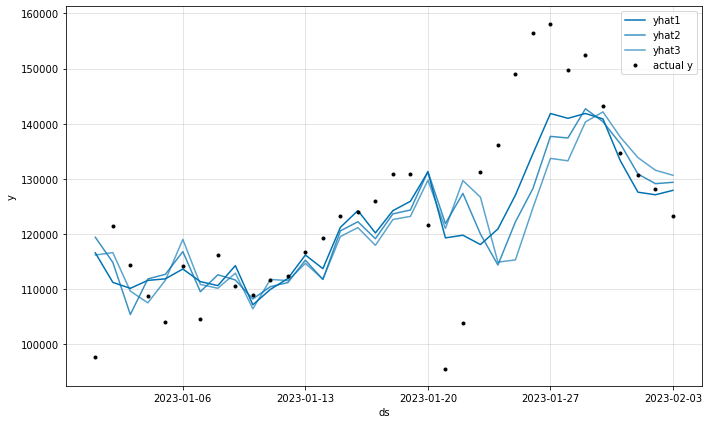

In [195]:
forecasts_plot = m.plot(predicted[predicted['ds']>='2023-01-01'])

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


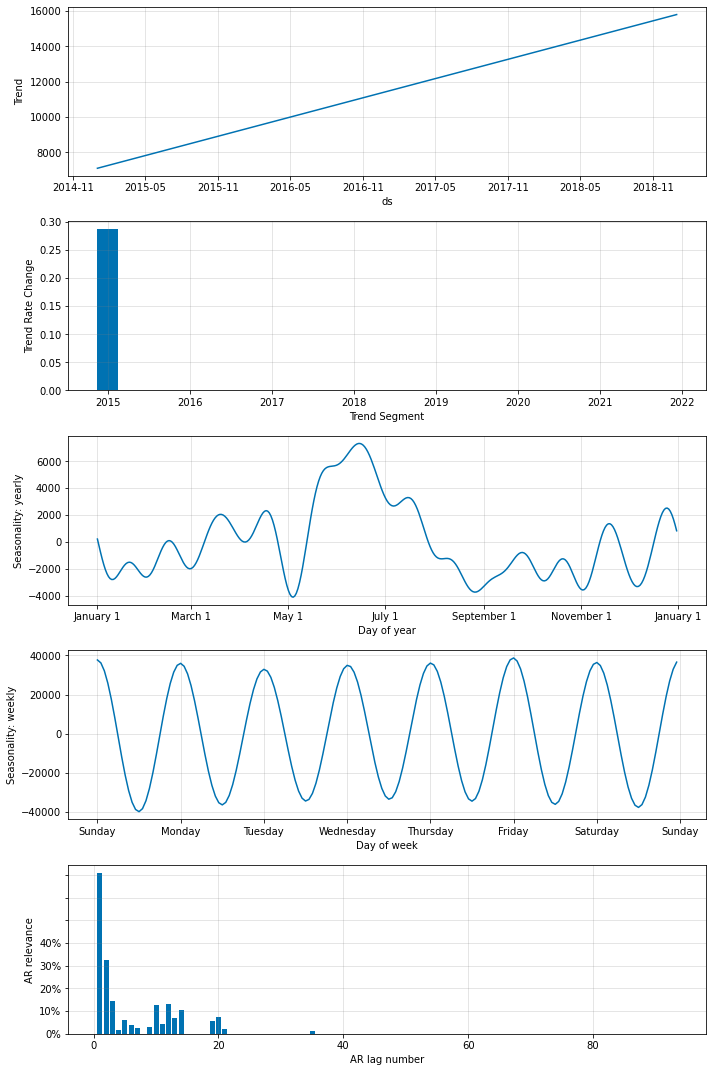

In [196]:
fig_param = m.plot_parameters()

In [197]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(predicted[predicted['ds']>='2023-01-01']['y'], predicted[predicted['ds']>='2023-01-01']['yhat1'])).round(2)
mape = np.round(np.mean(np.abs(predicted[predicted['ds']>='2023-01-01']['y']-predicted[predicted['ds']>='2023-01-01']['yhat1'])/predicted[predicted['ds']>='2023-01-01']['y'])*100,2)
tempResults = pd.DataFrame({'Method':'FB prophet', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,SARIMA,7,"257,177"
0,SARIMA with boxcox,3,"122,569"
0,prophet default,7,"252,779"
0,SARIMAX with covid period,55,"1,927,219"
0,prophet with covid holidays,10,"14,610"
0,FB prophet,6,"10,213"
0,FB prophet,6,"9,674"
0,FB prophet,6,"10,213"


In [198]:
np.mean(np.abs(predicted['y']-predicted['yhat1'])/predicted['y'])*100

5.641993511018582

In [199]:
df = m.create_df_with_events(dom,holidays)

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [200]:
df

,ds,y,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
0,2015-01-01,52356,0,0,0,0,0,0,0
1,2015-01-02,47811,0,0,0,0,0,0,0
2,2015-01-03,49555,0,0,0,0,0,0,0
3,2015-01-04,57680,0,0,0,0,0,0,0
4,2015-01-05,50193,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2951,2023-01-30,143151,0,0,0,0,0,1,0
2952,2023-01-31,134741,0,0,0,0,0,1,0
2953,2023-02-01,130693,0,0,0,0,0,0,0
2954,2023-02-02,128154,0,0,0,0,0,0,0


In [201]:
predict = m.predict(df = df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [202]:
np.round(np.mean(np.abs(predicted[predicted['ds']>='2023-01-01']['y']-predicted[predicted['ds']>='2023-01-01']['yhat1'])/predicted[predicted['ds']>='2023-01-01']['y'])*100,2)

6.2

In [203]:
np.round(np.mean(np.abs(predict[predict['ds']>='2023-01-01']['y']-predict[predict['ds']>='2023-01-01']['yhat1'])/predict[predict['ds']>='2023-01-01']['y'])*100,2)

6.2

In [204]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


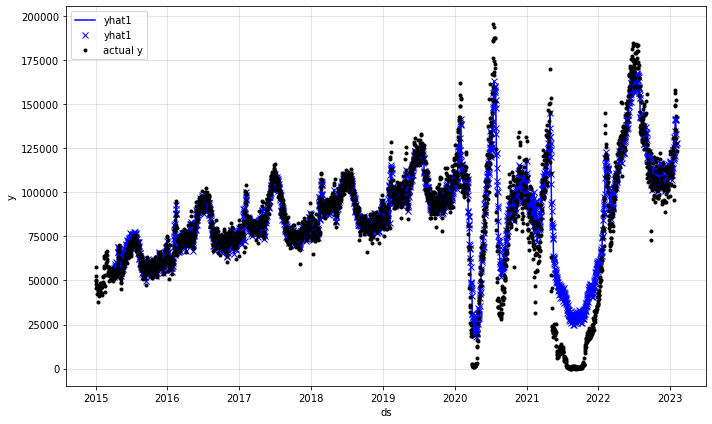

In [205]:
forecasts_plot = m.plot(predict)

In [206]:
predict.to_excel('result.xlsx')

In [207]:
np.round(np.mean(np.abs(predict[(predict['ds']>='2019-01-01')&(predict['ds']<'2020-01-01')]['y']-predict[(predict['ds']>='2019-01-01')&(predict['ds']<'2020-01-01')]['yhat1'])/predict[(predict['ds']>='2019-01-01')&(predict['ds']<'2020-01-01')]['y'])*100,2)

3.56